In [1]:
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from skimage.transform import resize
import cv2, skimage
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, Dropout, Flatten, Input, Add, GlobalAveragePooling2D, DepthwiseConv2D, BatchNormalization, LeakyReLU, Concatenate
from keras.models import Model
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from __future__ import print_function, unicode_literals

import tensorflow as tf
from sklearn.metrics import classification_report, precision_recall_fscore_support, recall_score, f1_score
sns.set()

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15862515038777927144, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7633841247420152595
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2682968031228712132
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14048107789469673823
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
datasetFeatures = np.load('/content/drive/My Drive/datasetRWTH/trainFeatures.npy')
datasetLabels = np.load('/content/drive/My Drive/datasetRWTH/trainLabels.npy')

In [0]:
keyFeaturesArray = np.load("/content/drive/My Drive/datasetRWTH/keyFeatures.npy")
keyLabelsArray = np.load("/content/drive/My Drive/datasetRWTH/keyLabels.npy")
keyLabelsDf = pd.DataFrame(keyLabelsArray, columns=["label", "person", "session", "camera"])
keyLabelsDf["keyIndex"] = keyLabelsDf.index

In [4]:
labelDf = pd.DataFrame(datasetLabels, columns=["label", "person", "session", "camera"])
labelDf = labelDf.merge(keyLabelsDf, on=["label", "person", "session", "camera"], how="left")
labelDf[labelDf["camera"] == "cam1"]

,label,person,session,camera,keyIndex
4,1,7,1,cam1,6.0
6,1,3,1,cam1,2.0
7,1,5,1,cam1,4.0
8,1,13,1,cam1,12.0
12,1,14,1,cam1,13.0
...,...,...,...,...,...
13193,35,13,1,cam1,592.0
13194,35,3,1,cam1,582.0
13196,35,4,1,cam1,583.0
13197,35,10,1,cam1,589.0


In [5]:
oneHotLabels = pd.get_dummies(labelDf, columns=['label'])
print(oneHotLabels.columns)
# print(testOneHotLabels.columns)

Index(['person', 'session', 'camera', 'keyIndex', 'label_1', 'label_11',
       'label_12', 'label_13', 'label_14', 'label_15', 'label_16', 'label_17',
       'label_18', 'label_19', 'label_2', 'label_20', 'label_21', 'label_22',
       'label_23', 'label_24', 'label_25', 'label_3', 'label_30', 'label_31',
       'label_32', 'label_33', 'label_34', 'label_35', 'label_4', 'label_5',
       'label_6', 'label_7', 'label_8', 'label_9'],
      dtype='object')


In [0]:
valLabels = oneHotLabels[(oneHotLabels["camera"] == "cam1") & (oneHotLabels["person"].isin(['17','18','19','20']))]
trainLabels = oneHotLabels[(oneHotLabels["camera"] == "cam1") & (~oneHotLabels["person"].isin(['17','18','19','20']))]
valLabels1 = valLabels.drop(["person", "session", "camera", "keyIndex"], axis=1)
trainLabels1 = trainLabels.drop(["person", "session", "camera", "keyIndex"], axis=1)

In [0]:
trainIndices = trainLabels1.sample(frac=1.0).index
valIndices = valLabels1.sample(frac=1.0).index

label_24


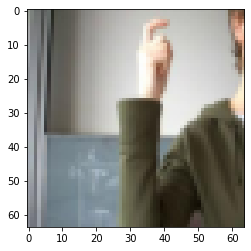

In [8]:
trainX = datasetFeatures[trainIndices].reshape(-1, 64, 64, 3)
trainY = trainLabels1.loc[trainIndices].values
valX = datasetFeatures[valIndices].reshape(-1, 64, 64, 3)
valY = valLabels1.loc[valIndices].values
plt.imshow(trainX[0])
print(trainLabels1.columns[np.argmax(trainY[0])])

In [0]:
del datasetFeatures
del datasetLabels

In [0]:
np.random.seed(None)
def getKpData(indices, lookupDf, keyFeatures):
  kpX = []
  for index in indices:
    keyIndex = int(lookupDf.loc[index, "keyIndex"])
    shift = np.ceil(np.random.normal(0,2))
    if np.random.binomial(1, p=0.4) == 1:
        shift = 0
    coords = keyFeatures[keyIndex].astype("int")
    coords = coords + int(shift)
    keyPoints = np.zeros((256, 256))
    keyPoints[coords[:,0], coords[:,1]]=1
    kpX.append(keyPoints.reshape(256, 256, 1))
  return np.array(kpX)


In [19]:

trainKpX = getKpData(trainIndices, trainLabels, keyFeaturesArray)
valKpX = getKpData(valIndices, valLabels, keyFeaturesArray)
trainKpX.shape

(5280, 256, 256, 1)

In [20]:
print(trainX.shape, trainY.shape)
print(valX.shape, valY.shape)
print(trainKpX.shape, trainY.shape)
print(valKpX.shape, valY.shape)

(5280, 64, 64, 3) (5280, 30)
(1320, 64, 64, 3) (1320, 30)
(5280, 256, 256, 1) (5280, 30)
(1320, 256, 256, 1) (1320, 30)


label_35


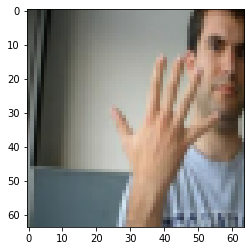

In [14]:
plt.imshow(trainX[22])
print(trainLabels1.columns[np.argmax(trainY[22])])

In [5]:
batchSize = 32
imageSize = 64
targetDims = (imageSize, imageSize, 3)
classes = 30
def getCNNModel():
  inputs = Input(shape=targetDims)
  # keyInputs = Input(shape=(256, 256, 1))
  net = Conv2D(32, kernel_size=3, strides=1, padding="same")(inputs)
  net = LeakyReLU()(net)
  net = Conv2D(32, kernel_size=3, strides=1, padding="same")(net)
  net = LeakyReLU()(net)
  net = Conv2D(32, kernel_size=3, strides=2, padding="same")(net)
  net = LeakyReLU()(net)

  net = Conv2D(32, kernel_size=3, strides=1, padding="same")(net)
  net = LeakyReLU()(net)
  net = Conv2D(32, kernel_size=3, strides=1, padding="same")(net)
  net = LeakyReLU()(net)
  net = Conv2D(32, kernel_size=3, strides=2, padding="same")(net)
  net = LeakyReLU()(net)

  shortcut = net

  net = DepthwiseConv2D(kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(net)
  net = BatchNormalization(axis=3)(net)
  net = LeakyReLU()(net)
  net = Conv2D(filters=32, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal')(net)
  net = BatchNormalization(axis=3)(net)
  net = LeakyReLU()(net)

  net = DepthwiseConv2D(kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(net)
  net = BatchNormalization(axis=3)(net)
  net = LeakyReLU()(net)
  net = Conv2D(filters=32, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal')(net)
  net = BatchNormalization(axis=3)(net)
  net = LeakyReLU()(net)

  net = Add()([net, shortcut])

  net = GlobalAveragePooling2D()(net)
  net = Dropout(0.2)(net)
  # kpnet = MaxPooling2D((4,4))(keyInputs)
  # kpnet = MaxPooling2D()(kpnet)
  # kpnet = MaxPooling2D()(kpnet)
  # kpnet = Flatten()(kpnet)
  # net = Concatenate()([net, kpnet])
  net = Dense(128, activation='relu')(net)
  outputs = Dense(classes, activation='softmax')(net)

  model = Model(inputs=[inputs], outputs=outputs)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
  return model


def getCombinedModel():
  inputs = Input(shape=targetDims)
  keyInputs = Input(shape=(256, 256, 1))
  net = Conv2D(32, kernel_size=3, strides=1, padding="same")(inputs)
  net = LeakyReLU()(net)
  net = Conv2D(32, kernel_size=3, strides=1, padding="same")(net)
  net = LeakyReLU()(net)
  net = Conv2D(32, kernel_size=3, strides=2, padding="same")(net)
  net = LeakyReLU()(net)

  net = Conv2D(32, kernel_size=3, strides=1, padding="same")(net)
  net = LeakyReLU()(net)
  net = Conv2D(32, kernel_size=3, strides=1, padding="same")(net)
  net = LeakyReLU()(net)
  net = Conv2D(32, kernel_size=3, strides=2, padding="same")(net)
  net = LeakyReLU()(net)

  shortcut = net

  net = DepthwiseConv2D(kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(net)
  net = BatchNormalization(axis=3)(net)
  net = LeakyReLU()(net)
  net = Conv2D(filters=32, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal')(net)
  net = BatchNormalization(axis=3)(net)
  net = LeakyReLU()(net)

  net = DepthwiseConv2D(kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(net)
  net = BatchNormalization(axis=3)(net)
  net = LeakyReLU()(net)
  net = Conv2D(filters=32, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal')(net)
  net = BatchNormalization(axis=3)(net)
  net = LeakyReLU()(net)

  net = Add()([net, shortcut])

  net = GlobalAveragePooling2D()(net)
  net = Dropout(0.2)(net)

  kpnet = MaxPooling2D((4,4))(keyInputs)
  kpnet = MaxPooling2D()(kpnet)
  kpnet = MaxPooling2D()(kpnet)
  kpnet = Flatten()(kpnet)
  kpnet = Dropout(0.2)(kpnet)
  net = Concatenate()([net, kpnet])
  net = Dense(128, activation='relu')(net)
  net = Dropout(0.5)(net) # for preventing overfitting
  outputs = Dense(classes, activation='softmax')(net)

  model = Model(inputs=[inputs, keyInputs], outputs=outputs)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
  return model
model = getCombinedModel()
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248    

In [28]:
model = getCombinedModel()
checkpoint = ModelCheckpoint('/content/drive/My Drive/datasetRWTH/combined-model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_acc',save_best_only=True, save_weights_only=True, mode='auto')  
history = model.fit([trainX, trainKpX], trainY, epochs=40, batch_size=batchSize, validation_data=([valX, valKpX], valY), verbose=1, callbacks=[checkpoint], initial_epoch=0)
# evaluate model

Train on 5280 samples, validate on 1320 samples
Epoch 1/40
5280/5280 [==============================] - 7s 1ms/step - loss: 3.0615 - acc: 0.1686 - val_loss: 3.1867 - val_acc: 0.1114

Epoch 00001: val_acc improved from -inf to 0.11136, saving model to /content/drive/My Drive/datasetRWTH/combined-model-001-0.168561-0.111364.h5
Epoch 2/40
5280/5280 [==============================] - 5s 937us/step - loss: 2.0841 - acc: 0.4396 - val_loss: 2.0146 - val_acc: 0.4470

Epoch 00002: val_acc improved from 0.11136 to 0.44697, saving model to /content/drive/My Drive/datasetRWTH/combined-model-002-0.439583-0.446970.h5
Epoch 3/40
5280/5280 [==============================] - 5s 946us/step - loss: 1.4286 - acc: 0.6070 - val_loss: 1.5744 - val_acc: 0.5242

Epoch 00003: val_acc improved from 0.44697 to 0.52424, saving model to /content/drive/My Drive/datasetRWTH/combined-model-003-0.607008-0.524242.h5
Epoch 4/40
5280/5280 [==============================] - 5s 933us/step - loss: 1.0411 - acc: 0.6996 - val_

In [29]:
model1 = getCNNModel()
checkpoint1 = ModelCheckpoint('/content/drive/My Drive/datasetRWTH/cnn-model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_acc',save_best_only=True, save_weights_only=True, mode='auto')  
history1 = model1.fit([trainX], trainY, epochs=40, batch_size=batchSize, validation_data=([valX], valY), verbose=1, callbacks=[checkpoint1], initial_epoch=0)

Train on 5280 samples, validate on 1320 samples
Epoch 1/40
5280/5280 [==============================] - 5s 1ms/step - loss: 3.4073 - acc: 0.0326 - val_loss: 3.4076 - val_acc: 0.0500

Epoch 00001: val_acc improved from -inf to 0.05000, saving model to /content/drive/My Drive/datasetRWTH/cnn-model-001-0.032576-0.050000.h5
Epoch 2/40
5280/5280 [==============================] - 3s 505us/step - loss: 3.1637 - acc: 0.0892 - val_loss: 2.9433 - val_acc: 0.1242

Epoch 00002: val_acc improved from 0.05000 to 0.12424, saving model to /content/drive/My Drive/datasetRWTH/cnn-model-002-0.089205-0.124242.h5
Epoch 3/40
5280/5280 [==============================] - 3s 500us/step - loss: 2.3528 - acc: 0.2528 - val_loss: 3.2647 - val_acc: 0.1447

Epoch 00003: val_acc improved from 0.12424 to 0.14470, saving model to /content/drive/My Drive/datasetRWTH/cnn-model-003-0.252841-0.144697.h5
Epoch 4/40
5280/5280 [==============================] - 3s 507us/step - loss: 1.6233 - acc: 0.4318 - val_loss: 3.4129 - 

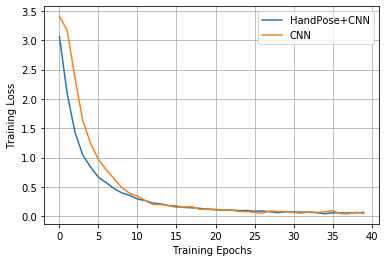

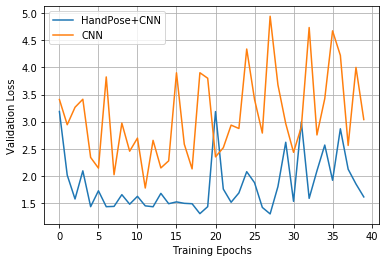

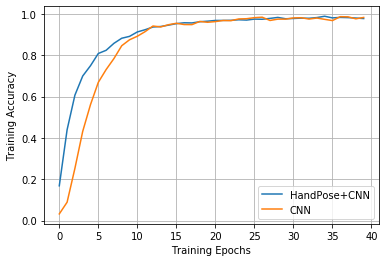

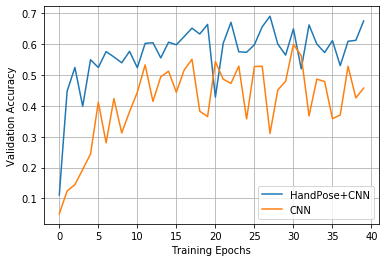

In [30]:
plt.plot(history.history['loss'], label="HandPose+CNN")
plt.plot(history1.history['loss'], label="CNN")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.grid()
plt.show()
plt.plot(history.history['val_loss'], label="HandPose+CNN")
plt.plot(history1.history['val_loss'], label="CNN")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history['acc'], label="HandPose+CNN")
plt.plot(history1.history['acc'], label="CNN")
plt.xlabel("Training Epochs")
plt.ylabel("Training Accuracy")
plt.legend()
plt.grid()
plt.show()
plt.plot(history.history['val_acc'], label="HandPose+CNN")
plt.plot(history1.history['val_acc'], label="CNN")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid()
plt.show()


In [0]:
del trainX
del trainKpX
del trainY

In [0]:
testFeatures = np.load('/content/drive/My Drive/datasetRWTH/testFeatures.npy')
testLabels = np.load('/content/drive/My Drive/datasetRWTH/testLabels.npy')
keyFeaturesTest = np.load("/content/drive/My Drive/datasetRWTH/testkeyFeatures.npy")
keyLabelsTest = np.load("/content/drive/My Drive/datasetRWTH/testkeyLabels.npy")
keyLabelsDf = pd.DataFrame(keyLabelsTest, columns=["label", "person", "session", "camera"])
keyLabelsDf["keyIndex"] = keyLabelsDf.index

In [0]:
testLabelDf = pd.DataFrame(testLabels, columns=["label", "person", "session", "camera"])
testLabelDf = testLabelDf.merge(keyLabelsDf, on=["label", "person", "session", "camera"], how="left")
testOneHotLabels = pd.get_dummies(testLabelDf, columns=['label'])
testLabels = testOneHotLabels[(testOneHotLabels["camera"] == "cam1")]
testLabels1 = testLabels.drop(["person", "session", "camera", "keyIndex"], axis=1)
testIndices = testLabels1.sample(frac=1.0).index
testX = testFeatures[testIndices].reshape(-1, 64, 64, 3)
testY = testLabels1.loc[testIndices].values

In [0]:
del testFeatures


In [0]:
testKpX = getKpData(testIndices, testLabels, keyFeaturesTest)

In [0]:
del testX
del testKpX
del testY

In [43]:
model = getCombinedModel()
model.load_weights("/content/drive/My Drive/datasetRWTH/combined-model-028-0.978409-0.690152.h5")
_, acc = model.evaluate([testX, testKpX], testY, verbose=1)
print('> %.3f' % (acc * 100.0))

6600/6600 [==============================] - 4s 534us/step
> 77.303


In [44]:
model1 = getCNNModel()
model1.load_weights("/content/drive/My Drive/datasetRWTH/cnn-model-031-0.980682-0.599242.h5")
_, acc = model1.evaluate([testX], testY, verbose=1)
print('> %.3f' % (acc * 100.0))

6600/6600 [==============================] - 1s 221us/step
> 68.697


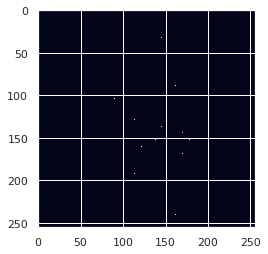

In [45]:
plt.imshow(testKpX[33].reshape(256,256))

In [46]:
testLabels1.columns[np.argmax(testY[33])]

'label_11'

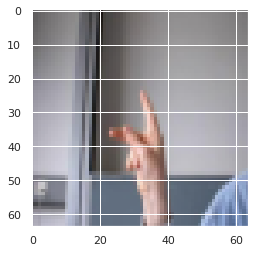

In [47]:
plt.imshow(testX[33])

In [0]:
predictionTest = model.predict([testX, testKpX])
bestPrediction = np.argmax(predictionTest, axis = 1)
actualLabel = np.argmax(testY, axis = 1)

In [49]:
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "SCH", "1", "2", "3", "4", "5"]
cols = ["A", "K", "L",
       "M", "N", "O", 'P', 'Q', 'R',
       'S', 'B', 'T', 'U', 'V', 'W',
       'X', 'Y', 'C', 'SCH', '1', '2',
       '3', '4', '5', 'D', 'E', 'F',
       'G', 'H', 'I']

print(classification_report(actualLabel, bestPrediction, target_names=cols))

              precision    recall  f1-score   support

           A       0.77      0.89      0.82       220
           K       0.63      0.75      0.69       220
           L       0.94      0.96      0.95       220
           M       0.38      0.28      0.32       220
           N       0.69      0.37      0.48       220
           O       0.71      0.88      0.78       220
           P       0.86      0.90      0.88       220
           Q       0.87      0.85      0.86       220
           R       0.60      0.70      0.65       220
           S       0.60      0.74      0.66       220
           B       0.83      0.80      0.82       220
           T       0.73      0.69      0.71       220
           U       0.90      0.78      0.83       220
           V       0.95      0.71      0.81       220
           W       0.87      0.94      0.90       220
           X       0.81      0.84      0.83       220
           Y       0.95      0.82      0.88       220
           C       0.79    

In [0]:
cmat = confusion_matrix(actualLabel, bestPrediction)
cmatDf = pd.DataFrame(cmat, columns=cols)
cmatDf.index = cols
cmatDf = cmatDf[labels]
cmatDf = cmatDf.loc[labels]
cmatDf.to_csv("/content/drive/My Drive/datasetRWTH/confusion_matrix_combined.csv")
# cmatDf

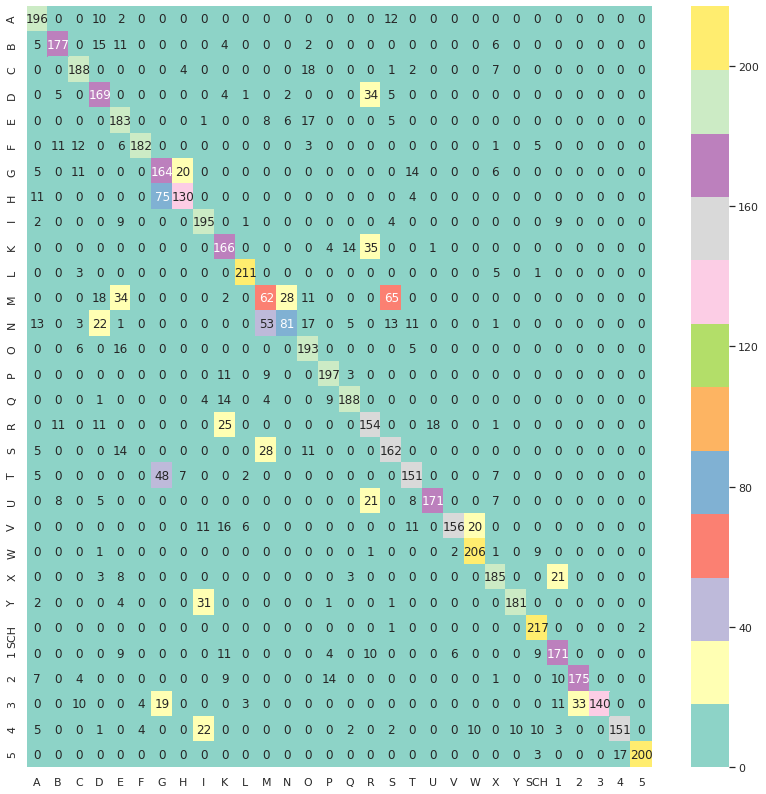

In [62]:
import matplotlib.cm as cm

plt.figure(figsize = (14,14))
sns.heatmap(cmatDf, annot=True, fmt='.3g', cmap=cm.Set3)
plt.show()

In [0]:
predictionTest1 = model1.predict([testX])
bestPrediction1 = np.argmax(predictionTest1, axis = 1)
actualLabel1 = np.argmax(testY, axis = 1)

In [64]:
print(classification_report(actualLabel1, bestPrediction1, target_names=cols))

              precision    recall  f1-score   support

           A       0.52      0.84      0.64       220
           K       0.56      0.44      0.49       220
           L       0.94      0.62      0.75       220
           M       0.60      0.43      0.50       220
           N       0.60      0.23      0.33       220
           O       0.78      0.65      0.71       220
           P       0.98      0.85      0.91       220
           Q       0.67      0.91      0.77       220
           R       0.75      0.47      0.58       220
           S       0.46      0.58      0.51       220
           B       0.57      0.78      0.66       220
           T       0.63      0.58      0.60       220
           U       0.54      0.65      0.59       220
           V       0.94      0.79      0.86       220
           W       0.87      0.53      0.66       220
           X       0.76      0.68      0.72       220
           Y       0.67      0.86      0.75       220
           C       0.72    

In [0]:
cmat = confusion_matrix(actualLabel1, bestPrediction1)
cmatDf = pd.DataFrame(cmat, columns=cols)
cmatDf.index = cols
cmatDf = cmatDf[labels]
cmatDf = cmatDf.loc[labels]
cmatDf.to_csv("/content/drive/My Drive/datasetRWTH/confusion_matrix_cnn.csv")
# cmatDf

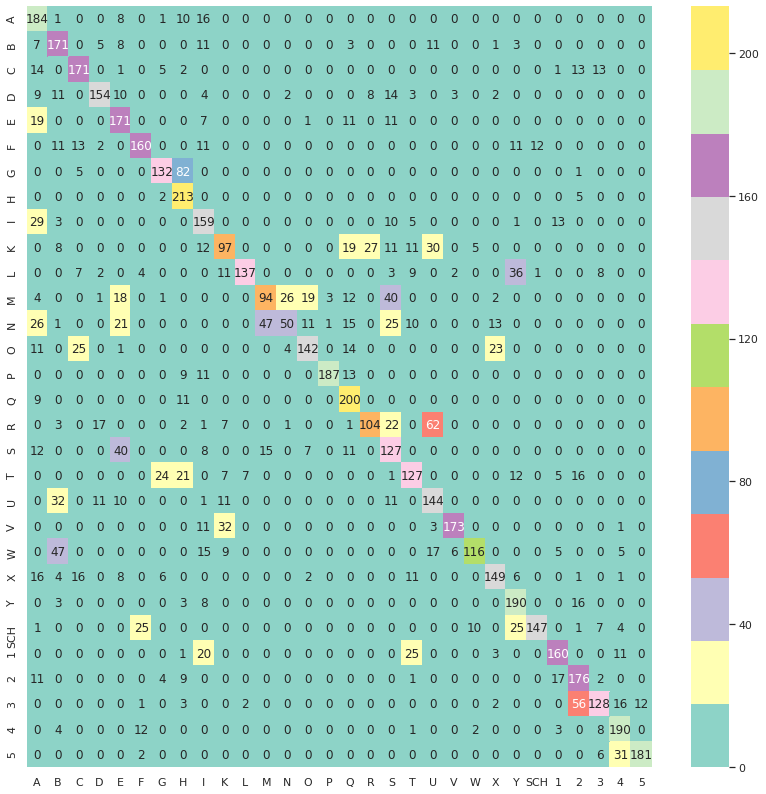

In [66]:
plt.figure(figsize = (14,14))
sns.heatmap(cmatDf, annot=True, fmt='.3g', cmap=cm.Set3)
plt.show()

In [0]:
combinedMetrics = precision_recall_fscore_support(actualLabel, bestPrediction)
cnnMetrics = precision_recall_fscore_support(actualLabel1, bestPrediction1)

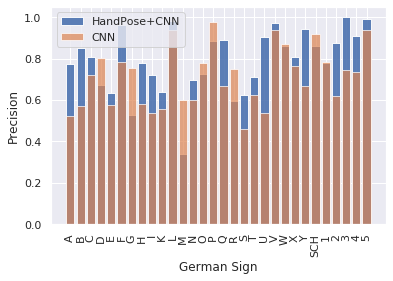

In [23]:
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "SCH", "1", "2", "3", "4", "5"]
cols = ["A", "K", "L",
       "M", "N", "O", 'P', 'Q', 'R',
       'S', 'B', 'T', 'U', 'V', 'W',
       'X', 'Y', 'C', 'SCH', '1', '2',
       '3', '4', '5', 'D', 'E', 'F',
       'G', 'H', 'I']
order = [cols.index(c) for c in labels]

plt.bar(labels, combinedMetrics[0][order], alpha=0.9, label="HandPose+CNN")
plt.bar(labels, cnnMetrics[0][order], alpha=0.7, label="CNN")
plt.legend()
plt.xlabel("German Sign")
plt.ylabel("Precision")
plt.xticks(rotation='vertical')
plt.show()

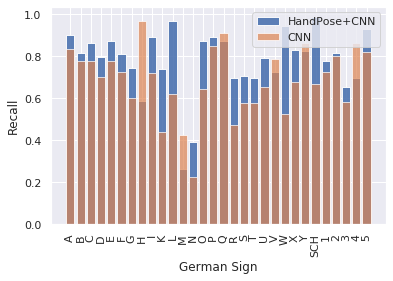

In [24]:
plt.bar(labels, combinedMetrics[1][order], alpha=0.9, label="HandPose+CNN")
plt.bar(labels, cnnMetrics[1][order], alpha=0.7, label="CNN")
plt.legend()
plt.xlabel("German Sign")
plt.ylabel("Recall")
plt.xticks(rotation='vertical')
plt.show()

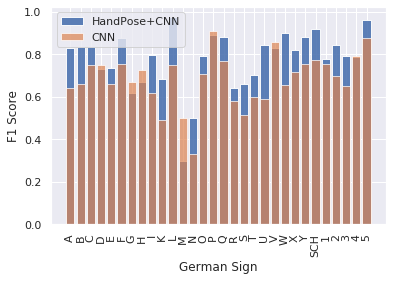

In [25]:
plt.bar(labels, combinedMetrics[2][order], alpha=0.9, label="HandPose+CNN")
plt.bar(labels, cnnMetrics[2][order], alpha=0.7, label="CNN")
plt.legend()
plt.xlabel("German Sign")
plt.ylabel("F1 Score")
plt.xticks(rotation='vertical')
plt.show()

In [19]:
np.random.seed(6)
np.random.normal(0,2)

-0.6235673469750332

In [0]:
sns.heatmap?